In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = "AAPL"  # Example: Apple Inc.

# Fetch historical market data
ticker = yf.Ticker(ticker_symbol)
hist = ticker.history(period="10y",interval="1d")  # Data for the past 1 month

# Save data to CSV
csv_filename = f"{ticker_symbol}_data.csv"
hist.to_csv(csv_filename)

print(f"CSV file saved as: {csv_filename}")

In [ ]:
import yfinance as yf
import pandas as pd

# Define the ticker symbol
ticker_symbol = "AAPL"  # Example: Apple Inc.

# Fetch historical market data
ticker = yf.Ticker(ticker_symbol)
hist = ticker.history(period="1mo")  # Data for the past 1 month
print(hist)
# Save data to CSV
csv_filename = f"{ticker_symbol}_data.csv"
hist.to_csv(csv_filename)

print(f"CSV file saved as: {csv_filename}")

In [ ]:
data=pd.read_csv('/kaggle/input/hacktry-1/AAPL_data.xls')

In [ ]:
data.describe()

In [ ]:
data2=pd.read_csv('/kaggle/input/hacktry-1-2/AAPL_data (1).xls')

In [ ]:
data2.describe()

In [ ]:
data2

In [ ]:
df=pd.read_csv('/kaggle/input/hacktry-1/AAPL_data.xls')
df['Date'] = pd.to_datetime(df['Date'], )

In [ ]:
df['Date'].dt.year

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Data Loading
# Assuming the data is already loaded into a DataFrame called 'df'
# If loading from the file:
df = pd.read_csv('/kaggle/input/hacktry-1/AAPL_data.xls')
df2 = df.copy()
df = df.iloc[:-1000,:].reset_index(drop=True)

# 2. Data Preprocessing
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Create date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Target variable - we'll predict the Close price
target_col = 'Close'

# Define features
price_features = ['Open', 'High', 'Low', 'Close', 'Volume']
date_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'Quarter', 'WeekOfYear']
features = price_features + date_features

# Create technical indicators
# 1. Moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 2. Price change
df['Price_Change'] = df['Close'].pct_change()

# 3. Volatility (standard deviation of price changes)
df['Volatility'] = df['Price_Change'].rolling(window=10).std()

# Add these new features to our feature list
tech_features = ['MA5', 'MA10', 'MA20', 'Price_Change', 'Volatility']
features.extend(tech_features)

# Drop rows with NaN values (due to rolling calculations)
df = df.dropna()

# 3. Train-Test Split
# Use the last 60 days for validation
split_idx = len(df) - 60
train_data = df.iloc[:split_idx]
val_data = df.iloc[split_idx:]

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

# 4. Feature Scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit on training data only
train_features = feature_scaler.fit_transform(train_data[features])
train_target = target_scaler.fit_transform(train_data[[target_col]])

# Transform validation data
val_features = feature_scaler.transform(val_data[features])
val_target = target_scaler.transform(val_data[[target_col]])

# 5. Time Series Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, features, target, seq_length=10):
        self.features = features
        self.target = target
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.features) - self.seq_length
    
    def __getitem__(self, idx):
        # Get sequence of features
        x = self.features[idx:idx+self.seq_length]
        # Get next target value
        y = self.target[idx+self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Sequence length (number of time steps to look back)
seq_length = 10

# Create datasets
train_dataset = TimeSeriesDataset(train_features, train_target, seq_length)
val_dataset = TimeSeriesDataset(val_features, val_target, seq_length)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# 6. LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get output from the last time step
        out = out[:, -1, :]
        
        # Pass through the fully connected layer
        out = self.fc(out)
        
        return out

# Model hyperparameters
input_size = len(features)  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1

# Initialize model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# 7. Training
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Number of epochs
num_epochs = 50

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item()
    
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    # Print progress
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# 8. Evaluation and Prediction
# Create arrays to store actual and predicted values
y_actual = []
y_pred = []

model.eval()
with torch.no_grad():
    for i in range(len(val_dataset)):
        inputs, targets = val_dataset[i]
        inputs = inputs.unsqueeze(0)  # Add batch dimension
        outputs = model(inputs)
        
        # Add to lists
        y_actual.append(targets.numpy())
        y_pred.append(outputs.numpy()[0])

# Convert to numpy arrays
y_actual = np.array(y_actual)
y_pred = np.array(y_pred)

# Inverse transform to get actual prices
y_actual_orig = target_scaler.inverse_transform(y_actual)
y_pred_orig = target_scaler.inverse_transform(y_pred)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_actual_orig, y_pred_orig)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_actual_orig, y_pred_orig)
r2 = r2_score(y_actual_orig, y_pred_orig)

print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.4f}')

# 9. Visualization
# Plot loss curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Plot actual vs predicted prices
val_dates = val_data['Date'].iloc[seq_length:]
plt.figure(figsize=(12, 6))
plt.plot(val_dates, y_actual_orig, label='Actual Prices')
plt.plot(val_dates, y_pred_orig, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Price Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 10. Future Prediction
# Predict the next 7 days
def predict_future(model, last_sequence, n_steps=7):
    model.eval()
    future_predictions = []
    
    # Use the last sequence from validation data as input
    input_sequence = last_sequence.clone()
    
    for _ in range(n_steps):
        with torch.no_grad():
            input_tensor = input_sequence.unsqueeze(0)  # Add batch dimension
            prediction = model(input_tensor)
            
            # Store the prediction
            future_predictions.append(prediction.numpy()[0])
            
            # Update the input sequence
            # Remove the first element and add the prediction
            new_features = np.zeros(input_size)
            new_features[3] = prediction.item()  # Close price is at index 3
            
            # Update input sequence by removing first row and adding new row
            input_sequence = torch.cat([input_sequence[1:], torch.FloatTensor([new_features])], dim=0)
    
    # Convert to numpy array and inverse transform
    future_predictions = np.array(future_predictions)
    future_prices = target_scaler.inverse_transform(future_predictions)
    
    return future_prices

# Get the last sequence from the validation dataset
last_sequence = torch.FloatTensor(val_features[-seq_length:])

# Predict the next 7 days
future_prices = predict_future(model, last_sequence)

# Create future dates
last_date = val_data['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=7, freq='B')

print("\nPredicted prices for the next 7 business days:")
for date, price in zip(future_dates, future_prices):
    print(f"{date.date()}: ${price[0]:.2f}")

# Plot future predictions
plt.figure(figsize=(12, 6))
plt.plot(val_dates[-30:], y_actual_orig[-30:], label='Actual Prices', color='blue')
plt.plot(val_dates[-30:], y_pred_orig[-30:], label='Predicted Prices', color='green')
plt.plot(future_dates, future_prices, label='Future Predictions', color='red', linestyle='--', marker='o')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('AAPL Stock Price Future Prediction')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from datetime import datetime
import math

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Data Loading
df = pd.read_csv('/kaggle/input/hacktry-1-2/AAPL_data (1).xls')

# 2. Data Preprocessing
# Convert date to datetime
df['Date'] = pd.to_datetime(df['Date'],utc=True)

# Create date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['DayOfYear'] = df['Date'].dt.dayofyear
df['Quarter'] = df['Date'].dt.quarter
df['WeekOfYear'] = df['Date'].dt.isocalendar().week

# Target variable - we'll predict the Close price
target_col = 'Close'

# Define features
price_features = ['Open', 'High', 'Low', 'Close', 'Volume']
date_features = ['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear', 'Quarter', 'WeekOfYear']
features = price_features + date_features

# Create technical indicators
# 1. Moving averages
df['MA5'] = df['Close'].rolling(window=5).mean()
df['MA10'] = df['Close'].rolling(window=10).mean()
df['MA20'] = df['Close'].rolling(window=20).mean()

# 2. Price change
df['Price_Change'] = df['Close'].pct_change()

# 3. Volatility (standard deviation of price changes)
df['Volatility'] = df['Price_Change'].rolling(window=10).std()

# 4. Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    diff = data.diff()
    up = diff.clip(lower=0)
    down = -diff.clip(upper=0)
    
    ma_up = up.rolling(window=window).mean()
    ma_down = down.rolling(window=window).mean()
    
    rs = ma_up / ma_down
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = calculate_rsi(df['Close'])

# Add these new features to our feature list
tech_features = ['MA5', 'MA10', 'MA20', 'Price_Change', 'Volatility', 'RSI']
features.extend(tech_features)

# Drop rows with NaN values (due to rolling calculations)
df = df.dropna()

# Convert number of days to sequence steps (since we're dealing with trading days, not calendar days)
# Note: There are approximately 252 trading days in a year
TRADING_DAYS_PER_YEAR = 252

# For our example:
# - We'll use real_seq_length for real data (approx 5 years of trading days)
# - And pred_seq_length for predicted data (approx 5 years of trading days)
real_seq_length = int(5 * TRADING_DAYS_PER_YEAR)  # 5 years of real data
pred_seq_length = int(5 * TRADING_DAYS_PER_YEAR)  # 5 years of predicted data
total_seq_length = real_seq_length + pred_seq_length

# Check if we have enough data
if len(df) < total_seq_length + 100:  # Need extra data for meaningful validation
    print(f"Warning: Not enough data for {real_seq_length + pred_seq_length} sequence length!")
    # Adjust sequence lengths based on available data
    available_length = len(df) - 100  # Reserve some for validation
    if available_length < 100:
        print("Error: Not enough data for meaningful analysis!")
        # Use shorter periods for demonstration
        real_seq_length = int(len(df) * 0.2)  # 20% of data for real sequence
        pred_seq_length = int(len(df) * 0.2)  # 20% of data for predicted sequence
    else:
        real_seq_length = int(available_length * 0.5)
        pred_seq_length = int(available_length * 0.5)

print(f"Using {real_seq_length} real data points and {pred_seq_length} predicted data points")

# Split data for initial model training
# We'll keep last 60 days for validation
split_idx = len(df) - 60
train_data = df.iloc[:split_idx]
val_data = df.iloc[split_idx:]

print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(val_data)}")

# Feature Scaling
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Fit on all data for consistent scaling
all_features = feature_scaler.fit_transform(df[features])
all_target = target_scaler.fit_transform(df[[target_col]])

# Scale train and validation sets
train_features = feature_scaler.transform(train_data[features])
train_target = target_scaler.transform(train_data[[target_col]])

val_features = feature_scaler.transform(val_data[features])
val_target = target_scaler.transform(val_data[[target_col]])

# Time Series Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, features, target, seq_length=10):
        self.features = features
        self.target = target
        self.seq_length = seq_length
        
    def __len__(self):
        return len(self.features) - self.seq_length
    
    def __getitem__(self, idx):
        # Get sequence of features
        x = self.features[idx:idx+self.seq_length]
        # Get next target value
        y = self.target[idx+self.seq_length]
        return torch.FloatTensor(x), torch.FloatTensor(y)

# Create datasets for initial model training
initial_seq_length = 20  # Use shorter sequence for initial model
train_dataset = TimeSeriesDataset(train_features, train_target, initial_seq_length)
val_dataset = TimeSeriesDataset(val_features, val_target, initial_seq_length)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        
        # Fully connected layers
        self.fc1 = nn.Linear(hidden_size, 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(32, output_size)
        
    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get output from the last time step
        out = out[:, -1, :]
        
        # Pass through fully connected layers
        out = self.fc1(out)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        
        return out

# Model hyperparameters
input_size = len(features)  # Number of features
hidden_size = 64
num_layers = 2
output_size = 1

# Initialize model
model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

# Number of epochs
num_epochs = 100

# Early stopping
patience = 10
best_val_loss = float('inf')
counter = 0

# Lists to store losses
train_losses = []
val_losses = []

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    running_val_loss = 0.0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, targets)
            running_val_loss += val_loss.item()
    
    val_loss = running_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    # Learning rate scheduler
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping at epoch {epoch+1}')
            break
    
    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

# Hybrid Prediction Function
def hybrid_prediction(model, all_features, all_target, real_seq_length, pred_seq_length):
    """
    Makes predictions using a hybrid approach:
    - First part of input sequence is actual data
    - Second part is predicted data
    
    Returns predictions, actual values, and indices of prediction points
    """
    model.eval()
    predictions = []
    actual_values = []
    pred_indices = []
    
    # Get the total length of data
    data_length = len(all_features)
    
    # Total sequence length needed for prediction
    total_seq_length = real_seq_length + pred_seq_length
    
    # We can only predict points that have enough data before them
    # The first point we can predict is at index total_seq_length
    # We need pred_seq_length predicted points BEFORE the point we're predicting
    
    # Start from the first valid prediction point
    # This is where we have enough data to include both real and predicted segments
    start_idx = total_seq_length
    
    # For each possible prediction point
    for i in range(start_idx, data_length):
        # Record this as a prediction point
        pred_indices.append(i)
        
        # Initialize prediction sequence
        # First part is real data
        real_data_start = i - total_seq_length
        real_data_end = real_data_start + real_seq_length
        pred_seq = all_features[real_data_start:real_data_end].copy()
        
        # Now generate predicted data for the second part of the sequence
        for j in range(pred_seq_length):
            # Get current position in overall sequence
            current_idx = real_data_end + j
            
            # Get the sequence to use for this prediction
            if j == 0:
                # First prediction uses only real data
                input_seq = torch.FloatTensor(all_features[current_idx-initial_seq_length:current_idx]).unsqueeze(0)
            else:
                # Subsequent predictions use a mix of real and predicted data
                # Take the last initial_seq_length points from our growing sequence
                input_seq = torch.FloatTensor(pred_seq[-initial_seq_length:]).unsqueeze(0)
            
            # Make prediction
            with torch.no_grad():
                pred = model(input_seq)
            
            # Create a new feature vector based on the last one
            new_features = all_features[current_idx-1].copy()
            # Update the Close price (index 3)
            new_features[3] = pred.item()
            
            # Add to our prediction sequence
            pred_seq = np.vstack([pred_seq, [new_features]])
        
        # Now we have a complete sequence with real + predicted data
        # Use it to predict the next point
        final_input_seq = torch.FloatTensor(pred_seq[-initial_seq_length:]).unsqueeze(0)
        
        with torch.no_grad():
            final_pred = model(final_input_seq)
        
        # Store prediction and actual value
        predictions.append(final_pred.item())
        actual_values.append(all_target[i][0])
    
    # Convert to numpy arrays
    predictions = np.array(predictions).reshape(-1, 1)
    actual_values = np.array(actual_values).reshape(-1, 1)
    
    # Inverse transform to get actual prices
    predictions_orig = target_scaler.inverse_transform(predictions)
    actual_values_orig = target_scaler.inverse_transform(actual_values)
    
    return predictions_orig, actual_values_orig, pred_indices

# Perform hybrid prediction
print("\nPerforming hybrid prediction using 5 years real + 5 years predicted data...")
predictions, actual_values, pred_indices = hybrid_prediction(
    model, all_features, all_target, real_seq_length, pred_seq_length)

# Calculate metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(actual_values, predictions)
r2 = r2_score(actual_values, predictions)

print("\nHybrid Prediction Metrics:")
print(f'Mean Squared Error: {mse:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')
print(f'Mean Absolute Error: {mae:.2f}')
print(f'R-squared: {r2:.4f}')

# Get dates for predictions
pred_dates = df.iloc[pred_indices]['Date'].reset_index(drop=True)

# Visualize predictions
plt.figure(figsize=(15, 8))
plt.plot(pred_dates, actual_values, label='Actual Prices', marker='o', markersize=3)
plt.plot(pred_dates, predictions, label='Hybrid Predictions', marker='x', markersize=3)
plt.xlabel('Date')
plt.ylabel('Stock Price ($)')
plt.title('Hybrid Prediction: Actual vs Predicted Stock Prices\n(Using 5 Years Real + 5 Years Predicted Data)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Visualize error distribution
errors = actual_values - predictions
plt.figure(figsize=(12, 6))
plt.hist(errors, bins=50, alpha=0.7)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatter plot of actual vs predicted
plt.figure(figsize=(10, 10))
plt.scatter(actual_values, predictions, alpha=0.5)
plt.plot([min(actual_values), max(actual_values)], [min(actual_values), max(actual_values)], 'r--')
plt.xlabel('Actual Price ($)')
plt.ylabel('Predicted Price ($)')
plt.title('Actual vs Predicted Prices')
plt.grid(True)
plt.tight_layout()
plt.show()

# Time-based error analysis
plt.figure(figsize=(15, 6))
plt.plot(pred_dates, np.abs(errors), label='Absolute Error')
plt.plot(pred_dates, actual_values, label='Actual Price', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Absolute Prediction Error Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Report metrics by year
def calculate_metrics_by_year(dates, actual, predicted):
    df_results = pd.DataFrame({
        'Date': dates,
        'Actual': actual.flatten(),
        'Predicted': predicted.flatten(),
        'Error': (actual - predicted).flatten(),
        'AbsError': np.abs(actual - predicted).flatten(),
        'PercentError': np.abs((actual - predicted) / actual * 100).flatten()
    })
    
    df_results['Year'] = df_results['Date'].dt.year
    yearly_metrics = {}
    
    for year, group in df_results.groupby('Year'):
        yearly_metrics[year] = {
            'RMSE': np.sqrt(mean_squared_error(group['Actual'], group['Predicted'])),
            'MAE': mean_absolute_error(group['Actual'], group['Predicted']),
            'MAPE': group['PercentError'].mean(),
            'R2': r2_score(group['Actual'], group['Predicted']),
            'Count': len(group)
        }
    
    return yearly_metrics

yearly_metrics = calculate_metrics_by_year(pred_dates, actual_values, predictions)

print("\nYearly Performance Metrics:")
for year, metrics in yearly_metrics.items():
    print(f"\nYear {year} (n={metrics['Count']}):")
    print(f"  RMSE: ${metrics['RMSE']:.2f}")
    print(f"  MAE: ${metrics['MAE']:.2f}")
    print(f"  MAPE: {metrics['MAPE']:.2f}%")
    print(f"  R²: {metrics['R2']:.4f}")

# Plot yearly RMSE
years = list(yearly_metrics.keys())
rmse_values = [metrics['RMSE'] for metrics in yearly_metrics.values()]
mape_values = [metrics['MAPE'] for metrics in yearly_metrics.values()]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot RMSE bars
ax1.bar(years, rmse_values, alpha=0.7, color='blue', label='RMSE ($)')
ax1.set_xlabel('Year')
ax1.set_ylabel('RMSE ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create second y-axis for MAPE
ax2 = ax1.twinx()
ax2.plot(years, mape_values, 'ro-', label='MAPE (%)')
ax2.set_ylabel('MAPE (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legends
plt.title('Yearly Prediction Error Metrics')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

# Final analysis: Impact of prediction horizon
def analyze_prediction_horizon(model, all_features, all_target, target_scaler, test_idx=5000):
    """
    Analyze how prediction accuracy changes with prediction horizon
    """
    horizons = [1, 5, 10, 20, 60, 126, 252]  # 1 day, 1 week, 2 weeks, 1 month, 3 months, 6 months, 1 year
    results = {}
    
    # Use same test point for all horizons
    initial_seq = all_features[test_idx-initial_seq_length:test_idx]
    
    for horizon in horizons:
        # Make prediction
        model.eval()
        current_seq = initial_seq.copy()
        predictions = []
        
        # Generate predictions for the horizon
        for i in range(horizon):
            input_tensor = torch.FloatTensor(current_seq[-initial_seq_length:]).unsqueeze(0)
            
            with torch.no_grad():
                pred = model(input_tensor)
            
            predictions.append(pred.item())
            
            # Update sequence for next prediction
            new_features = current_seq[-1].copy()
            new_features[3] = pred.item()  # Update Close price
            current_seq = np.vstack([current_seq, [new_features]])
        
        # Get actual values
        actual = all_target[test_idx:test_idx+horizon].flatten()
        
        # Convert predictions to original scale
        pred_array = np.array(predictions).reshape(-1, 1)
        pred_orig = target_scaler.inverse_transform(pred_array).flatten()
        actual_orig = target_scaler.inverse_transform(all_target[test_idx:test_idx+horizon]).flatten()
        
        # Calculate metrics
        mse = mean_squared_error(actual_orig, pred_orig)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual_orig - pred_orig) / actual_orig)) * 100
        
        results[horizon] = {
            'RMSE': rmse,
            'MAPE': mape,
            'PredValues': pred_orig,
            'ActualValues': actual_orig
        }
    
    return results

# Run horizon analysis
horizon_results = analyze_prediction_horizon(model, all_features, all_target, target_scaler)

# Plot RMSE by prediction horizon
horizons = list(horizon_results.keys())
rmse_by_horizon = [results['RMSE'] for results in horizon_results.values()]
mape_by_horizon = [results['MAPE'] for results in horizon_results.values()]

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot RMSE line
ax1.plot(horizons, rmse_by_horizon, 'bo-', label='RMSE ($)')
ax1.set_xlabel('Prediction Horizon (Trading Days)')
ax1.set_ylabel('RMSE ($)', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xscale('log')  # Use log scale for x-axis

# Create second y-axis for MAPE
ax2 = ax1.twinx()
ax2.plot(horizons, mape_by_horizon, 'ro-', label='MAPE (%)')
ax2.set_ylabel('MAPE (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add title and legends
plt.title('Prediction Error by Horizon')
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.grid(True)
plt.show()

# Plot example predictions for different horizons
plt.figure(figsize=(15, 8))
for horizon in [1, 5, 20, 252]:  # 1 day, 1 week, 1 month, 1 year
    results = horizon_results[horizon]
    plt.plot(range(1, horizon+1), results['ActualValues'], 'o-', label=f'Actual - {horizon} days')
    plt.plot(range(1, horizon+1), results['PredValues'], 'x--', label=f'Predicted - {horizon} days')

plt.xlabel('Days from Prediction Point')
plt.ylabel('Stock Price ($)')
plt.title('Actual vs Predicted Prices for Different Horizons')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("\nSummary of Prediction Accuracy by Horizon:")
print("-" * 50)
print(f"{'Horizon (Days)':<15}{'RMSE ($)':<15}{'MAPE (%)':<15}")
print("-" * 50)
for horizon in horizons:
    print(f"{horizon:<15}{horizon_results[horizon]['RMSE']:<15.2f}{horizon_results[horizon]['MAPE']:<15.2f}")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgbm
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor

# Load the data
# Assuming the data is in a variable called 'data2' as shown in your screenshot
# If needed, adjust this part to load from your file
data = pd.read_csv('/kaggle/input/hacktry-1-2/AAPL_data (1).xls')

# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'],utc=True)
data = data.set_index('Date')

# Create time-independent features (technical indicators)
def create_features(df):
    # Create a copy of the dataframe to avoid modifying the original
    df_features = df.copy()
    
    # Price features
    df_features['return_1d'] = df_features['Close'].pct_change(1)
    df_features['return_5d'] = df_features['Close'].pct_change(5)
    df_features['return_10d'] = df_features['Close'].pct_change(10)
    
    # Volatility features
    df_features['volatility_5d'] = df_features['return_1d'].rolling(window=5).std()
    df_features['volatility_10d'] = df_features['return_1d'].rolling(window=10).std()
    df_features['volatility_20d'] = df_features['return_1d'].rolling(window=20).std()
    
    # Moving averages
    df_features['ma_5d'] = df_features['Close'].rolling(window=5).mean()
    df_features['ma_10d'] = df_features['Close'].rolling(window=10).mean()
    df_features['ma_20d'] = df_features['Close'].rolling(window=20).mean()
    df_features['ma_50d'] = df_features['Close'].rolling(window=50).mean()
    
    # Moving average crossovers
    df_features['ma_5d_10d'] = df_features['ma_5d'] - df_features['ma_10d']
    df_features['ma_10d_20d'] = df_features['ma_10d'] - df_features['ma_20d']
    df_features['ma_20d_50d'] = df_features['ma_20d'] - df_features['ma_50d']
    
    # RSI (Relative Strength Index)
    delta = df_features['Close'].diff()
    gain = delta.where(delta > 0, 0).rolling(window=14).mean()
    loss = -delta.where(delta < 0, 0).rolling(window=14).mean()
    rs = gain / loss
    df_features['RSI'] = 100 - (100 / (1 + rs))
    
    # MACD (Moving Average Convergence Divergence)
    ema_12 = df_features['Close'].ewm(span=12, adjust=False).mean()
    ema_26 = df_features['Close'].ewm(span=26, adjust=False).mean()
    df_features['MACD'] = ema_12 - ema_26
    df_features['MACD_signal'] = df_features['MACD'].ewm(span=9, adjust=False).mean()
    df_features['MACD_hist'] = df_features['MACD'] - df_features['MACD_signal']
    
    # Bollinger Bands
    df_features['bb_middle'] = df_features['Close'].rolling(window=20).mean()
    df_features['bb_std'] = df_features['Close'].rolling(window=20).std()
    df_features['bb_upper'] = df_features['bb_middle'] + 2 * df_features['bb_std']
    df_features['bb_lower'] = df_features['bb_middle'] - 2 * df_features['bb_std']
    df_features['bb_width'] = (df_features['bb_upper'] - df_features['bb_lower']) / df_features['bb_middle']
    df_features['bb_position'] = (df_features['Close'] - df_features['bb_lower']) / (df_features['bb_upper'] - df_features['bb_lower'])
    
    # Volume features
    df_features['volume_change'] = df_features['Volume'].pct_change()
    df_features['volume_ma_5d'] = df_features['Volume'].rolling(window=5).mean()
    df_features['volume_ma_10d'] = df_features['Volume'].rolling(window=10).mean()
    df_features['volume_ratio'] = df_features['Volume'] / df_features['volume_ma_5d']
    
    # High-Low Range features
    df_features['daily_range'] = (df_features['High'] - df_features['Low']) / df_features['Open']
    df_features['daily_range_ma_5d'] = df_features['daily_range'].rolling(window=5).mean()
    
    # Weekly/Monthly patterns - day of week, day of month, month of year
    df_features['day_of_week'] = df_features.index.dayofweek
    df_features['day_of_month'] = df_features.index.day
    df_features['month'] = df_features.index.month
    df_features['quarter'] = df_features.index.quarter
    
    return df_features

# Create lag features
def add_lag_features(df, lag_days=[1, 2, 3, 5, 10]):
    df_lag = df.copy()
    
    # Price lags
    for lag in lag_days:
        df_lag[f'close_lag_{lag}'] = df_lag['Close'].shift(lag)
        df_lag[f'open_lag_{lag}'] = df_lag['Open'].shift(lag)
        df_lag[f'high_lag_{lag}'] = df_lag['High'].shift(lag)
        df_lag[f'low_lag_{lag}'] = df_lag['Low'].shift(lag)
    
    # Return lags
    for lag in lag_days:
        df_lag[f'return_lag_{lag}'] = df_lag['return_1d'].shift(lag)
    
    # Volume lags
    for lag in lag_days:
        df_lag[f'volume_lag_{lag}'] = df_lag['Volume'].shift(lag)
        df_lag[f'volume_change_lag_{lag}'] = df_lag['volume_change'].shift(lag)
    
    # Rolling stats on returns
    df_lag['return_mean_5d'] = df_lag['return_1d'].rolling(window=5).mean().shift(1)
    df_lag['return_std_5d'] = df_lag['return_1d'].rolling(window=5).std().shift(1)
    df_lag['return_mean_10d'] = df_lag['return_1d'].rolling(window=10).mean().shift(1)
    df_lag['return_std_10d'] = df_lag['return_1d'].rolling(window=10).std().shift(1)
    
    return df_lag

# Create target variable - next day's closing price
def create_target(df, forward_days=1):
    df_target = df.copy()
    df_target['target'] = df_target['Close'].shift(-forward_days)
    return df_target

# Apply feature engineering
df_features = create_features(data)
df_with_lags = add_lag_features(df_features)
df_final = create_target(df_with_lags)

# Drop NaN values created by lag and rolling features
df_final = df_final.dropna()

# Create a proper train-test split (time-based, not random)
# Use approximately 85% for training, 15% for testing
split_idx = int(len(df_final) * 0.85)
train_data = df_final.iloc[:split_idx]
test_data = df_final.iloc[split_idx:]

# Alternatively, use a specific date for splitting
# train_data = df_final[df_final.index < '2022-01-01']
# test_data = df_final[df_final.index >= '2022-01-01']

print(f"Training data from {train_data.index.min()} to {train_data.index.max()}")
print(f"Testing data from {test_data.index.min()} to {test_data.index.max()}")

# Define features and target
feature_columns = [col for col in df_final.columns if col not in ['target', 'Date']]
X_train = train_data[feature_columns]
y_train = train_data['target']
X_test = test_data[feature_columns]
y_test = test_data['target']


# # Scale features
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
X_train = X_train.replace([np.inf, -np.inf], np.nan)  # Replace inf with NaN
X_train = X_train.fillna(X_train.median())  # Replace NaN with median values
X_test = X_test.replace([np.inf,-np.inf],np.nan)
X_test = X_test.fillna(X_test.median())
X_train_scaled=X_train
X_test=X_test

# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print("-" * 40)
    
    return predictions

# Feature importance plot
def plot_feature_importance(model, feature_names, model_name, top_n=20):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f'Feature Importance - {model_name}')
        plt.barh(range(min(top_n, len(indices))), 
                 importances[indices[:top_n]], 
                 align='center')
        plt.yticks(range(min(top_n, len(indices))), 
                   [feature_names[i] for i in indices[:top_n]])
        plt.xlabel('Relative Importance')
        plt.tight_layout()
        plt.show()

# Train LightGBM model
lgbm_model = lgbm.LGBMRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
lgbm_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    # early_stopping_rounds=50,
    # verbose=100
)

# Train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=50,
    verbose=100
)

# Train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=12,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf_model.fit(X_train, y_train)

# Evaluate models
lgbm_preds = evaluate_model(lgbm_model, X_test, y_test, "LightGBM")
xgb_preds = evaluate_model(xgb_model, X_test, y_test, "XGBoost")
rf_preds = evaluate_model(rf_model, X_test, y_test, "Random Forest")

# Plot feature importance
plot_feature_importance(lgbm_model, feature_columns, "LightGBM")
plot_feature_importance(xgb_model, feature_columns, "XGBoost")
plot_feature_importance(rf_model, feature_columns, "Random Forest")

# Visualize predictions
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual', color='black', alpha=0.7)
plt.plot(test_data.index, lgbm_preds, label='LightGBM', color='blue', alpha=0.7)
plt.plot(test_data.index, xgb_preds, label='XGBoost', color='red', alpha=0.7)
plt.plot(test_data.index, rf_preds, label='Random Forest', color='green', alpha=0.7)
plt.title('Stock Price Prediction Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

# Create an ensemble model (simple average of predictions)
ensemble_preds = (lgbm_preds + xgb_preds + rf_preds) / 3
ensemble_mse = mean_squared_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(ensemble_mse)
ensemble_mae = mean_absolute_error(y_test, ensemble_preds)
ensemble_r2 = r2_score(y_test, ensemble_preds)

print("Ensemble Model Performance:")
print(f"MSE: {ensemble_mse:.4f}")
print(f"RMSE: {ensemble_rmse:.4f}")
print(f"MAE: {ensemble_mae:.4f}")
print(f"R²: {ensemble_r2:.4f}")

# Visualize ensemble performance
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, y_test, label='Actual', color='black', alpha=0.7)
plt.plot(test_data.index, ensemble_preds, label='Ensemble', color='purple', linewidth=2)
plt.title('Ensemble Model Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
plt.show()

Epoch 1/50: 100%|██████████| 32/32 [00:00<00:00, 52.33it/s]


Epoch [1/50], Train Loss: 0.0191, Val Loss: 0.0310


Epoch 2/50: 100%|██████████| 32/32 [00:00<00:00, 276.09it/s]


Epoch [2/50], Train Loss: 0.0120, Val Loss: 0.0309


Epoch 3/50: 100%|██████████| 32/32 [00:00<00:00, 275.63it/s]


Epoch [3/50], Train Loss: 0.0111, Val Loss: 0.0309


Epoch 4/50: 100%|██████████| 32/32 [00:00<00:00, 252.80it/s]


Epoch [4/50], Train Loss: 0.0104, Val Loss: 0.0308


Epoch 5/50: 100%|██████████| 32/32 [00:00<00:00, 271.96it/s]


Epoch [5/50], Train Loss: 0.0103, Val Loss: 0.0309


Epoch 6/50: 100%|██████████| 32/32 [00:00<00:00, 277.17it/s]


Epoch [6/50], Train Loss: 0.0106, Val Loss: 0.0309


Epoch 7/50: 100%|██████████| 32/32 [00:00<00:00, 276.03it/s]


Epoch [7/50], Train Loss: 0.0104, Val Loss: 0.0309


Epoch 8/50: 100%|██████████| 32/32 [00:00<00:00, 277.87it/s]


Epoch [8/50], Train Loss: 0.0102, Val Loss: 0.0309


Epoch 9/50: 100%|██████████| 32/32 [00:00<00:00, 278.67it/s]


Epoch [9/50], Train Loss: 0.0104, Val Loss: 0.0309


Epoch 10/50: 100%|██████████| 32/32 [00:00<00:00, 276.68it/s]


Epoch [10/50], Train Loss: 0.0104, Val Loss: 0.0310


Epoch 11/50: 100%|██████████| 32/32 [00:00<00:00, 267.21it/s]


Epoch [11/50], Train Loss: 0.0105, Val Loss: 0.0310


Epoch 12/50: 100%|██████████| 32/32 [00:00<00:00, 273.27it/s]


Epoch [12/50], Train Loss: 0.0103, Val Loss: 0.0312


Epoch 13/50: 100%|██████████| 32/32 [00:00<00:00, 275.50it/s]


Epoch [13/50], Train Loss: 0.0106, Val Loss: 0.0310


Epoch 14/50: 100%|██████████| 32/32 [00:00<00:00, 271.54it/s]


Epoch [14/50], Train Loss: 0.0103, Val Loss: 0.0309


Epoch 15/50: 100%|██████████| 32/32 [00:00<00:00, 272.79it/s]


Epoch [15/50], Train Loss: 0.0103, Val Loss: 0.0310


Epoch 16/50: 100%|██████████| 32/32 [00:00<00:00, 277.32it/s]


Epoch [16/50], Train Loss: 0.0105, Val Loss: 0.0311


Epoch 17/50: 100%|██████████| 32/32 [00:00<00:00, 273.93it/s]


Epoch [17/50], Train Loss: 0.0104, Val Loss: 0.0312


Epoch 18/50: 100%|██████████| 32/32 [00:00<00:00, 274.73it/s]


Epoch [18/50], Train Loss: 0.0104, Val Loss: 0.0311


Epoch 19/50: 100%|██████████| 32/32 [00:00<00:00, 272.09it/s]


Epoch [19/50], Train Loss: 0.0108, Val Loss: 0.0310


Epoch 20/50: 100%|██████████| 32/32 [00:00<00:00, 275.74it/s]


Epoch [20/50], Train Loss: 0.0119, Val Loss: 0.0311


Epoch 21/50: 100%|██████████| 32/32 [00:00<00:00, 278.67it/s]


Epoch [21/50], Train Loss: 0.0104, Val Loss: 0.0310


Epoch 22/50: 100%|██████████| 32/32 [00:00<00:00, 276.23it/s]


Epoch [22/50], Train Loss: 0.0106, Val Loss: 0.0310


Epoch 23/50: 100%|██████████| 32/32 [00:00<00:00, 269.87it/s]


Epoch [23/50], Train Loss: 0.0104, Val Loss: 0.0310


Epoch 24/50: 100%|██████████| 32/32 [00:00<00:00, 269.21it/s]


Epoch [24/50], Train Loss: 0.0104, Val Loss: 0.0310


Epoch 25/50: 100%|██████████| 32/32 [00:00<00:00, 277.28it/s]


Epoch [25/50], Train Loss: 0.0103, Val Loss: 0.0314


Epoch 26/50: 100%|██████████| 32/32 [00:00<00:00, 277.43it/s]


Epoch [26/50], Train Loss: 0.0110, Val Loss: 0.0311


Epoch 27/50: 100%|██████████| 32/32 [00:00<00:00, 276.05it/s]


Epoch [27/50], Train Loss: 0.0104, Val Loss: 0.0311


Epoch 28/50: 100%|██████████| 32/32 [00:00<00:00, 281.14it/s]


Epoch [28/50], Train Loss: 0.0106, Val Loss: 0.0313


Epoch 29/50: 100%|██████████| 32/32 [00:00<00:00, 277.61it/s]


Epoch [29/50], Train Loss: 0.0108, Val Loss: 0.0311


Epoch 30/50: 100%|██████████| 32/32 [00:00<00:00, 275.44it/s]


Epoch [30/50], Train Loss: 0.0108, Val Loss: 0.0311


Epoch 31/50: 100%|██████████| 32/32 [00:00<00:00, 276.47it/s]


Epoch [31/50], Train Loss: 0.0107, Val Loss: 0.0312


Epoch 32/50: 100%|██████████| 32/32 [00:00<00:00, 272.64it/s]


Epoch [32/50], Train Loss: 0.0109, Val Loss: 0.0310


Epoch 33/50: 100%|██████████| 32/32 [00:00<00:00, 277.85it/s]


Epoch [33/50], Train Loss: 0.0105, Val Loss: 0.0310


Epoch 34/50: 100%|██████████| 32/32 [00:00<00:00, 279.51it/s]


Epoch [34/50], Train Loss: 0.0102, Val Loss: 0.0310


Epoch 35/50: 100%|██████████| 32/32 [00:00<00:00, 270.65it/s]


Epoch [35/50], Train Loss: 0.0113, Val Loss: 0.0314


Epoch 36/50: 100%|██████████| 32/32 [00:00<00:00, 275.93it/s]


Epoch [36/50], Train Loss: 0.0109, Val Loss: 0.0312


Epoch 37/50: 100%|██████████| 32/32 [00:00<00:00, 270.31it/s]


Epoch [37/50], Train Loss: 0.0106, Val Loss: 0.0311


Epoch 38/50: 100%|██████████| 32/32 [00:00<00:00, 269.45it/s]


Epoch [38/50], Train Loss: 0.0103, Val Loss: 0.0311


Epoch 39/50: 100%|██████████| 32/32 [00:00<00:00, 276.96it/s]


Epoch [39/50], Train Loss: 0.0104, Val Loss: 0.0311


Epoch 40/50: 100%|██████████| 32/32 [00:00<00:00, 278.19it/s]


Epoch [40/50], Train Loss: 0.0104, Val Loss: 0.0311


Epoch 41/50: 100%|██████████| 32/32 [00:00<00:00, 282.39it/s]


Epoch [41/50], Train Loss: 0.0103, Val Loss: 0.0313


Epoch 42/50: 100%|██████████| 32/32 [00:00<00:00, 275.40it/s]


Epoch [42/50], Train Loss: 0.0104, Val Loss: 0.0311


Epoch 43/50: 100%|██████████| 32/32 [00:00<00:00, 269.91it/s]


Epoch [43/50], Train Loss: 0.0106, Val Loss: 0.0311


Epoch 44/50: 100%|██████████| 32/32 [00:00<00:00, 272.73it/s]


Epoch [44/50], Train Loss: 0.0107, Val Loss: 0.0311


Epoch 45/50: 100%|██████████| 32/32 [00:00<00:00, 273.58it/s]


Epoch [45/50], Train Loss: 0.0105, Val Loss: 0.0311


Epoch 46/50: 100%|██████████| 32/32 [00:00<00:00, 275.60it/s]


Epoch [46/50], Train Loss: 0.0104, Val Loss: 0.0311


Epoch 47/50: 100%|██████████| 32/32 [00:00<00:00, 272.05it/s]


Epoch [47/50], Train Loss: 0.0103, Val Loss: 0.0312


Epoch 48/50: 100%|██████████| 32/32 [00:00<00:00, 274.36it/s]


Epoch [48/50], Train Loss: 0.0103, Val Loss: 0.0311


Epoch 49/50: 100%|██████████| 32/32 [00:00<00:00, 276.28it/s]


Epoch [49/50], Train Loss: 0.0103, Val Loss: 0.0311


Epoch 50/50: 100%|██████████| 32/32 [00:00<00:00, 273.95it/s]


Epoch [50/50], Train Loss: 0.0104, Val Loss: 0.0311


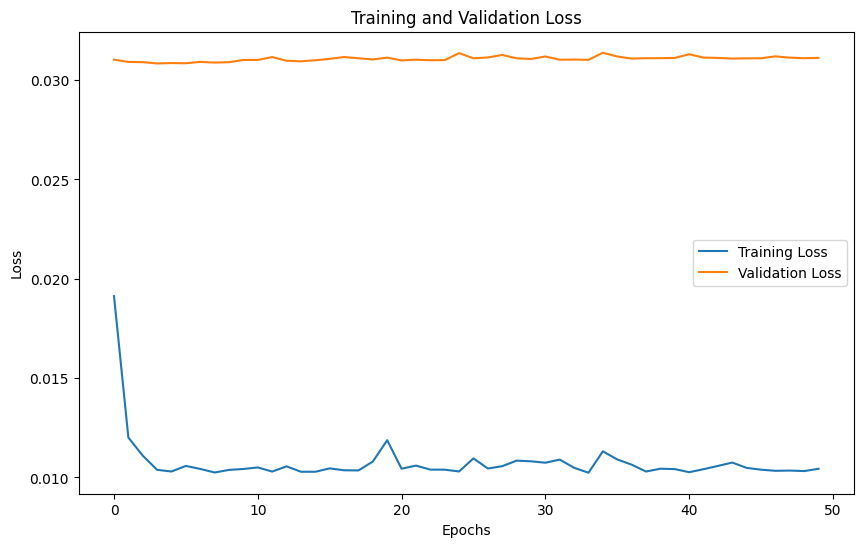

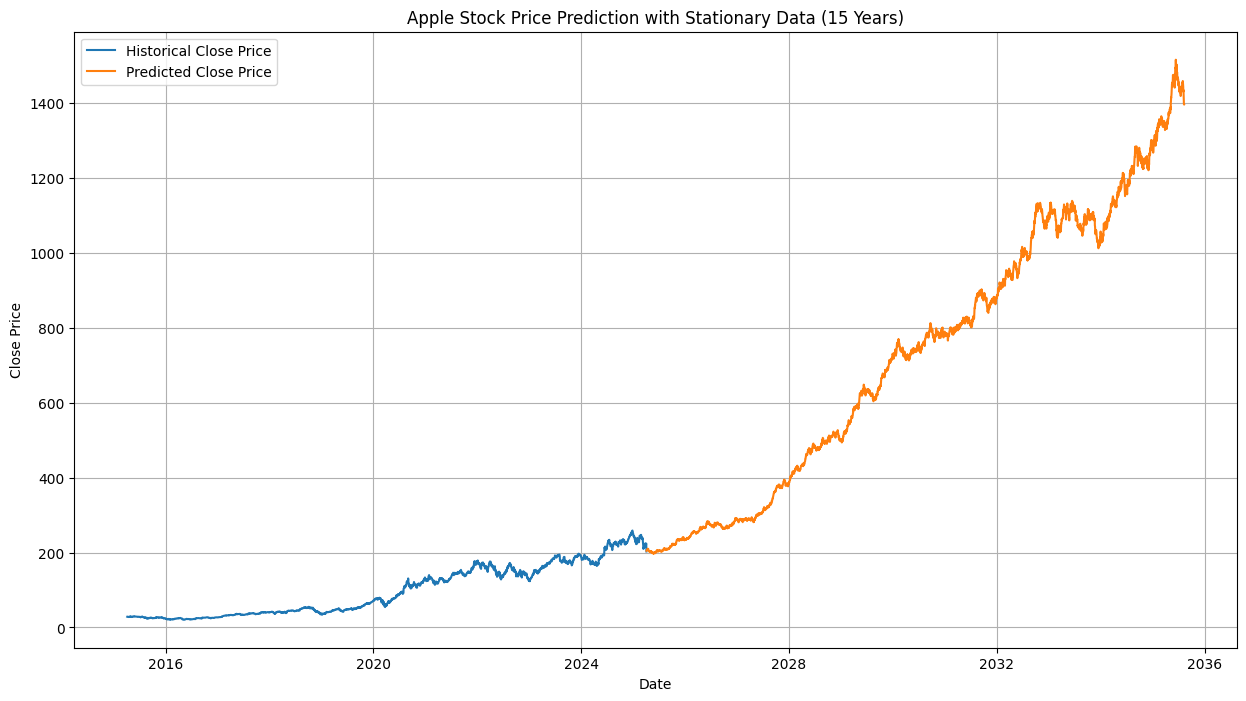

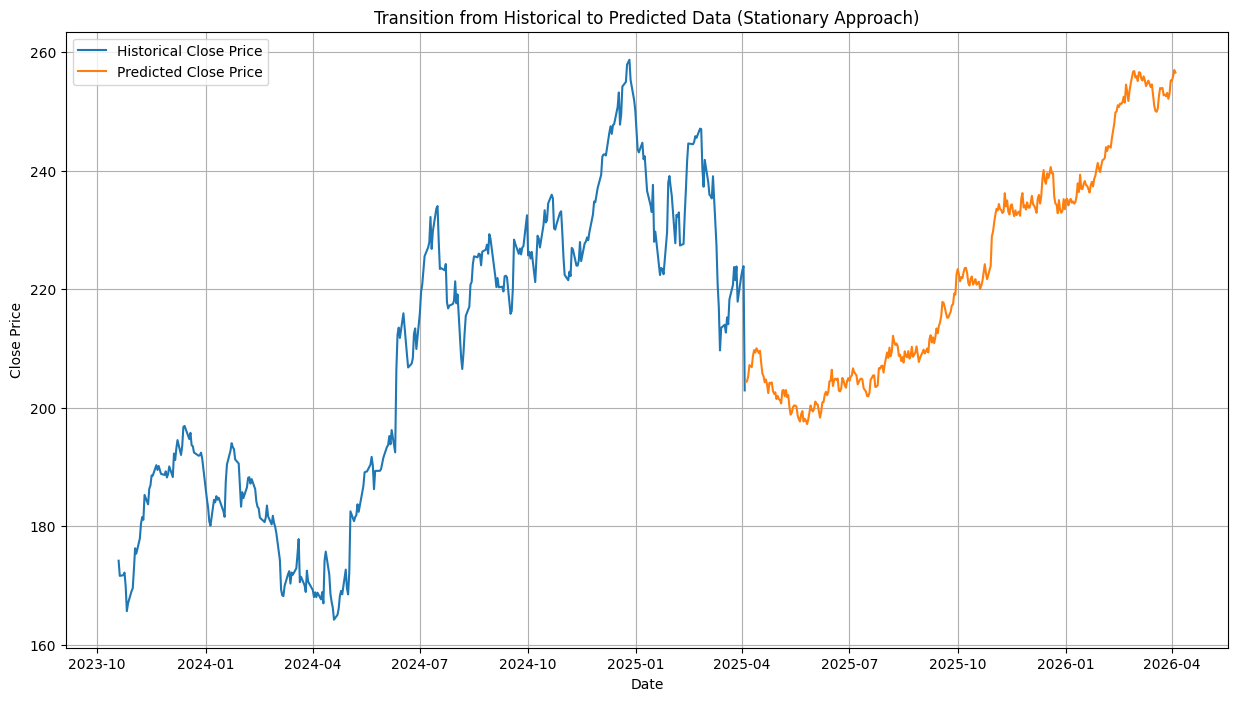

Validation MAPE on reconstructed prices: 7.71%


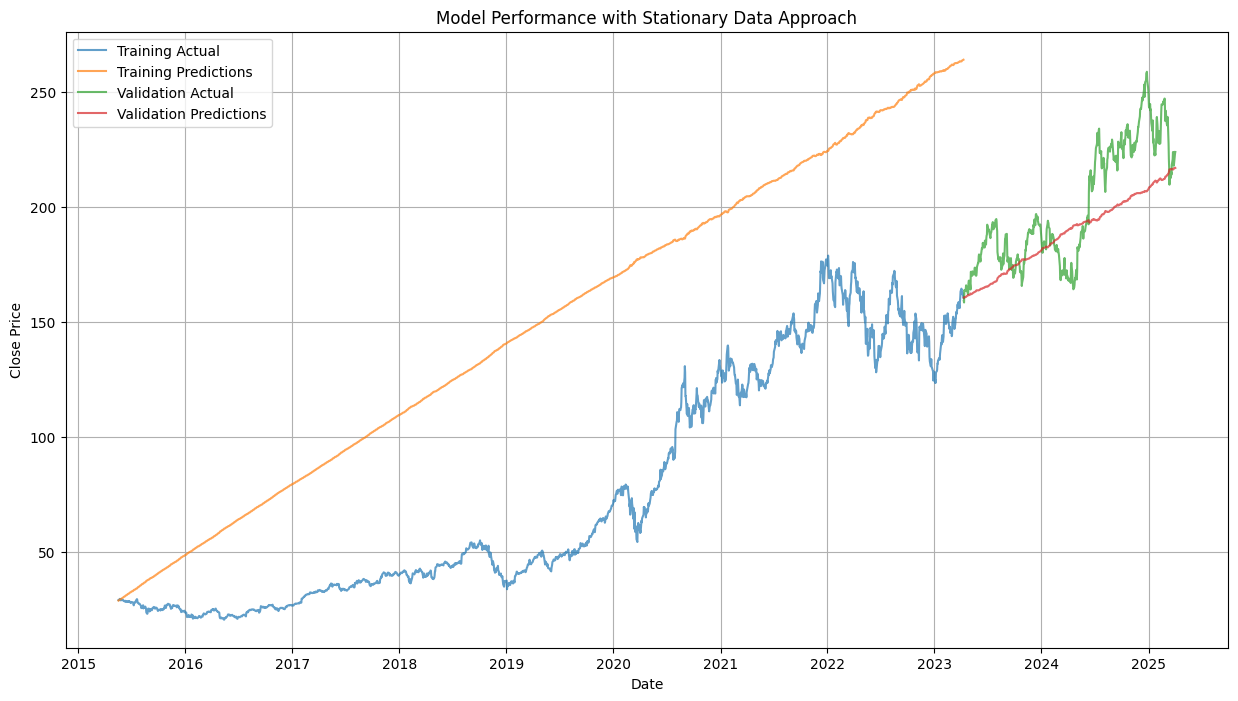

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
import datetime
from tqdm import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the data
data_path = "/kaggle/input/hacktry-1/AAPL_data.xls"
df = pd.read_csv(data_path)

# Convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'], utc=True)

# Sort by date
df = df.sort_values('Date')

# Set date as index
df.set_index('Date', inplace=True)

# Extract the closing prices and convert to float
close_prices = df['Close'].values.astype(float).reshape(-1, 1)

# Create stationary data using differencing
diff_close_prices = np.diff(close_prices, axis=0)
first_price = close_prices[0][0]  # Save for later re-integration

# Normalize the differenced data
scaler_diff = MinMaxScaler(feature_range=(-1, 1))
diff_scaled = scaler_diff.fit_transform(diff_close_prices)

# Function to create sequences
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

# Define sequence length (at least a month of trading days)
seq_length = 30  # Approximately 1.5 months of trading days

# Create sequences from stationary data
X, y = create_sequences(diff_scaled, seq_length)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into training and validation sets (80/20) - keeping original split method
train_size = int(len(X) * 0.8)
X_train, X_val = X_tensor[:train_size], X_tensor[train_size:]
y_train, y_val = y_tensor[:train_size], y_tensor[train_size:]

# Create DataLoader
batch_size = 64
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define the BiLSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, output_size=1):
        super(BiLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # BiLSTM layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size * 2, output_size)  # *2 because bidirectional
    
    def forward(self, x):
        # Initialize hidden state and cell state
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)  # *2 because bidirectional
        c0 = torch.zeros(self.num_layers * 2, batch_size, self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get output from last time step
        out = self.fc(out[:, -1, :])
        
        return out

# Initialize model, loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = BiLSTMModel().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses

# Train the model
num_epochs = 50
train_losses, val_losses = train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('loss_plot.png')
plt.show()

# Function to predict future values with Geometric Brownian Motion
def predict_future(model, last_sequence, steps, scaler_diff):
    model.eval()
    
    # Initialize arrays for differences and actual prices
    future_diffs = []
    future_prices = []
    
    # Start with the last actual price
    last_actual_price = close_prices[-1][0]
    current_price = last_actual_price
    future_prices.append(current_price)
    
    # Create a copy of the last sequence for prediction
    current_sequence = last_sequence.clone()
    
    # Parameters for Geometric Brownian Motion
    # Calculate from historical data
    log_returns = np.diff(np.log(close_prices), axis=0)
    mu = np.mean(log_returns) * 252  # Annualized drift
    sigma = np.std(log_returns) * np.sqrt(252)  # Annualized volatility
    
    # Daily parameters
    daily_mu = mu / 252
    daily_sigma = sigma / np.sqrt(252)
    
    for _ in range(steps):
        with torch.no_grad():
            # Get model prediction for next difference
            current_sequence_tensor = current_sequence.unsqueeze(0).to(device)
            pred_diff_scaled = model(current_sequence_tensor)
            
            # Inverse transform to get actual difference
            pred_diff = scaler_diff.inverse_transform(pred_diff_scaled.cpu().numpy())[0][0]
            
            # Use GBM to add stochastic component to the predicted difference
            dt = 1  # One day
            drift = (daily_mu - 0.5 * daily_sigma**2) * dt
            diffusion = daily_sigma * np.sqrt(dt) * np.random.normal(0, 1)
            
            # Combine model prediction with GBM
            # The model predicts the direction and magnitude, GBM adds realistic noise
            stochastic_factor = np.exp(drift + diffusion)
            adjustment = current_price * (stochastic_factor - 1)
            
            # Blend model prediction with GBM (can adjust the weight)
            blend_weight = 0.7  # Higher weight to model prediction
            blended_diff = (blend_weight * pred_diff) + ((1 - blend_weight) * adjustment)
            
            # Calculate next price
            next_price = current_price + blended_diff
            
            # Ensure price doesn't go negative
            next_price = max(0.01, next_price)
            
            # Store results
            future_diffs.append(blended_diff)
            future_prices.append(next_price)
            
            # Update current price
            current_price = next_price
            
            # Update sequence for next prediction (with the scaled difference)
            new_diff_scaled = torch.tensor([[pred_diff_scaled.item()]], dtype=torch.float32)
            current_sequence = torch.cat([current_sequence[1:], new_diff_scaled], dim=0)
    
    future_prices = np.array(future_prices[1:]).reshape(-1, 1)  # Remove the initial price
    
    return future_prices

# Get the last sequence of differences for prediction
last_diff_sequence = torch.tensor(diff_scaled[-seq_length:], dtype=torch.float32)

# Predict 15 years of daily data (assuming ~252 trading days per year)
future_days = 252 * 15
future_prices = predict_future(model, last_diff_sequence, future_days, scaler_diff)

# Create future dates
last_date = df.index[-1]
future_dates = [last_date + datetime.timedelta(days=i+1) for i in range(future_days)]
future_dates_df = pd.DataFrame(index=future_dates, data={'Predicted_Close': future_prices.flatten()})

# Plot historical and predicted prices
plt.figure(figsize=(15, 8))
plt.plot(df.index, df['Close'], label='Historical Close Price')
plt.plot(future_dates_df.index, future_dates_df['Predicted_Close'], label='Predicted Close Price')
plt.title('Apple Stock Price Prediction with Stationary Data (15 Years)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('stationary_prediction_plot.png')
plt.show()

# Create a zoomed-in plot of the transition period
transition_start = df.index[-365]  # Last year of historical data
transition_end = future_dates[365]  # First year of prediction
transition_df = pd.concat([
    df.loc[transition_start:, 'Close'],
    future_dates_df.loc[:transition_end, 'Predicted_Close']
])

plt.figure(figsize=(15, 8))
plt.plot(df.loc[transition_start:, 'Close'].index, df.loc[transition_start:, 'Close'], label='Historical Close Price')
plt.plot(future_dates_df.loc[:transition_end, 'Predicted_Close'].index, future_dates_df.loc[:transition_end, 'Predicted_Close'], label='Predicted Close Price')
plt.title('Transition from Historical to Predicted Data (Stationary Approach)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('stationary_transition_plot.png')
plt.show()

# Function to reconvert predictions for evaluation
def reconvert_diff_predictions(y_pred_scaled, scaler_diff):
    # Inverse transform scaled differences
    y_pred_diff = scaler_diff.inverse_transform(y_pred_scaled)
    return y_pred_diff

# Calculate reconstruction accuracy on training and validation data
def calculate_reconstructed_prices(orig_prices, diff_pred, start_idx):
    reconstructed = [orig_prices[start_idx-1][0]]  # Start with the price before the sequence
    
    for diff in diff_pred:
        next_price = reconstructed[-1] + diff[0]
        reconstructed.append(next_price)
    
    return np.array(reconstructed[1:]).reshape(-1, 1)  # Skip the first value

# Evaluate on validation data
model.eval()
with torch.no_grad():
    # Get predictions for validation data
    val_pred_scaled = model(X_val.to(device)).cpu().numpy()
    val_pred_diff = reconvert_diff_predictions(val_pred_scaled, scaler_diff)
    
    # Get the actual differences for validation
    val_actual_diff = scaler_diff.inverse_transform(y_val.numpy())
    
    # Calculate the starting index for validation data
    val_start_idx = seq_length + len(X_train)
    
    # Reconstruct prices from differences
    val_reconstructed = calculate_reconstructed_prices(close_prices, val_pred_diff, val_start_idx)
    val_actual_prices = close_prices[val_start_idx:val_start_idx+len(val_pred_diff)]
    
    # Calculate MAPE on actual prices
    mape = np.mean(np.abs((val_actual_prices - val_reconstructed) / val_actual_prices)) * 100
    print(f"Validation MAPE on reconstructed prices: {mape:.2f}%")

# Do the same for training data
with torch.no_grad():
    train_pred_scaled = model(X_train.to(device)).cpu().numpy()
    train_pred_diff = reconvert_diff_predictions(train_pred_scaled, scaler_diff)
    
    train_start_idx = seq_length
    train_reconstructed = calculate_reconstructed_prices(close_prices, train_pred_diff, train_start_idx)
    train_actual_prices = close_prices[train_start_idx:train_start_idx+len(train_pred_diff)]

# Plot the training and validation predictions against actual values
plt.figure(figsize=(15, 8))

# Get dates for plotting
train_dates = df.index[seq_length:seq_length+len(train_reconstructed)]
val_dates = df.index[val_start_idx:val_start_idx+len(val_reconstructed)]

# Plot training predictions
plt.plot(train_dates, train_actual_prices, label='Training Actual', alpha=0.7)
plt.plot(train_dates, train_reconstructed, label='Training Predictions', alpha=0.7)

# Plot validation predictions
plt.plot(val_dates, val_actual_prices, label='Validation Actual', alpha=0.7)
plt.plot(val_dates, val_reconstructed, label='Validation Predictions', alpha=0.7)

plt.title('Model Performance with Stationary Data Approach')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.savefig('stationary_model_performance.png')
plt.show()

# Save the predictions to CSV
future_dates_df.to_csv('apple_stock_predictions_stationary_15years.csv')

# 